In [1]:
import os
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
import warnings
warnings.filterwarnings("ignore")

D:\LenovoSoftstore\Install\anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# calculate RF 
#----
def RF_feature(shallow, deep, max_depth, estimators, name, features=False):
    shallow['depth_label'] = np.zeros(shallow.shape[0], dtype=int)
    deep['depth_label'] = np.ones(deep.shape[0], dtype=int)
    
    #select shalow randomly
    shallow_sample = shallow.sample(n=deep.shape[0], replace=False, random_state=42, axis=0)
   
    #merge
    df =pd.concat([shallow_sample, deep])
    
    #train and test
    if features:
        X = df[features].copy()
    else:
        X = df.drop(columns=['apparent_stress', 'depth', 'depth_label', 'Er/Mw']).copy()
    Y = df.copy()
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=42, stratify=Y['depth_label'])
    clf = RandomForestClassifier(n_estimators= estimators, max_depth=max_depth, class_weight='balanced', random_state=42)
    model = clf.fit(X_train, y_train['depth_label'])
    print('\n')
    print('Training: {}; Testing: {}'.format(X_train.shape[0], X_test.shape[0]))
    print('Classification accuracy {:.3f}'.format(clf.score(X_test, y_test['depth_label'])))
    #============#
    y_pred = clf.predict(X_test)
    print(confusion_matrix(y_test['depth_label'], y_pred))
    # y_test['pred_label'] = y_pred
    # y_test.to_csv('out/file/'+name+'.csv',index=False,sep=',')
    #==============#
    print('Feature importance:')
    idx = np.argsort(clf.feature_importances_,)
    features_order = []
    feature_importance = []
    feature_acc = [0.5]
    for i in idx[::-1]: 
        print('{:s} {:.3f}'.format(X.columns[i], clf.feature_importances_[i]))
        features_order.append(X.columns[i])
        feature_importance.append(clf.feature_importances_[i])

    for i in range(len(features_order)):
        clf2 = RandomForestClassifier(n_estimators=10, max_depth=3, class_weight='balanced', random_state=12)
        clf2.fit(X_train[features_order[0:i+1]], y_train['depth_label'])
        feature_acc.append(clf2.score(X_test[features_order[0:i+1]], y_test['depth_label']))   
    AccracyFeature(feature_acc, feature_importance, features_order)   

# The changes in classification accuracy by progressively adding the 
# features as input and retraining and re-evaluating the classifier
def AccracyFeature(accuracy, importance, features):
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(np.arange(len(accuracy)), accuracy, c="#20639B")
    plt.ylabel("Accuracy (%)", fontsize=15)
    plt.xticks([])
    plt.xlim(0, (len(importance)+1))
    plt.yticks([0.4, 0.5, 0.75, 1.0], ['', 50, 75, 100], fontsize=10)
    plt.subplot(2, 1, 2)
    plt.scatter(np.arange(len(importance))+1, importance, c="#ED553B")
    plt.ylabel("Weight", fontsize=15)
    plt.xticks(np.arange(len(importance))+1, features, rotation=45, fontsize=10)
    #plt.axis([0, 0.3, 0, int(len(importance)+1)])
    plt.xlim(0, (len(importance)+1))
    plt.subplots_adjust(hspace=0)
    plt.show()
    

# Repeat 100 times and calculate the mean accuracy and standard error
def RF_score(shallow, deep, max_depth, estimators, features=False):
    score = []
    shallow['depth_label'] = np.zeros(shallow.shape[0], dtype=int)
    deep['depth_label'] = np.ones(deep.shape[0], dtype=int)
    for i in range(100):
        
        # Randomly select some shallow (intermediate-depth) EQs to match the total number of deep (deep-focus)EQs
        shallow_sample = shallow.sample(n=deep.shape[0], replace=False, random_state=i, axis=0)
        
        # merge
        df =pd.concat([shallow_sample, deep])
        
        # train and test
        if features:
            X = df[features].copy()
        else:
            X = df.drop(columns=['apparent_stress', 'depth', 'depth_label', 'Er/Mw']).copy()
        Y = df.copy()
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=i, stratify=Y['depth_label'])
        clf = RandomForestClassifier(n_estimators= estimators, max_depth=max_depth, class_weight='balanced', random_state=i)
        clf.fit(X_train, y_train['depth_label'])
        score.append(clf.score(X_test, y_test['depth_label']))

    print("Average accuracy, std:\n", np.mean(np.asarray(score)), np.std(np.asarray(score)))
#------------#


# dichotomy
#----------#
def linear_score(shallow, deep, features=False):
    shallow['depth_label'] = np.zeros(shallow.shape[0], dtype=int)
    deep['depth_label'] = np.ones(deep.shape[0], dtype=int)
   
    #select
    score = []
    feature_name = []
    
    #  Repeat 100 times and calculate the mean accuracy and standard error
    for i in range(100):
        
        # Randomly select some shallow (intermediate-depth) EQs to match the total number of deep (deep-focus)EQs
        shallow_sample = shallow.sample(n=deep.shape[0], replace=False, random_state=i, axis=0)
        df =pd.concat([shallow_sample, deep])

        #train and test
        if features:
            X = df[features].copy()
        else:
            X = df.drop(columns=['Er/Mw', 'apparent_stress', 'depth', 'depth_label']).copy()
        Y = df['depth_label'].copy()
        
        # mean.std
        accuracy = []
        for feature in X.columns:
            if i == 0:                
                feature_name.append(feature)
            X_singal = X[feature].values
            X_singal = X_singal.reshape(-1, 1)
            clf = LinearSVC(class_weight='balanced')
            clf.fit(X_singal, Y.values.ravel())
            accuracy.append(clf.score(X_singal, Y.values.ravel()))
        score.append(accuracy)
    
    # save the results
    dichotomy = list(zip(feature_name, np.mean(np.asarray(score), axis=0), np.std(np.asarray(score), axis=0)))
    print("dichotomous accuracies:\n Feature\tAcc.\tstd\n", np.array(dichotomy))
    np.savetxt("out/dichotomous_accuracy.txt", np.array(dichotomy), fmt="%s", header="Feature\tAccuracy\tstd")
#---------------------#


# Spearman coefficient
#---------------------#
def spearman_value(df, X, independent):
    spearmans = np.zeros(len(X.columns))
    for i, feature in enumerate(X.columns):
        R = round(spearmanr(df[independent], df[feature])[0], 3)
        spearmans[i] = R
    return spearmans
#---------------------#


def plot_spearman(depth, fm, x_label="fm"):
    plt.figure(1,figsize=(5, 5))
    plt.scatter(fm, depth, c="k")
    plt.xlabel("spearman coefficient of "+ x_label)
    plt.ylabel("spearman coefficient of depth")
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
#     plt.savefig("out/png/spearman.png", format="png", bbox_inches='tight', dpi=600,pad_inches=0.0)
    plt.show()

The counts of EQS:
Shallow	deep	intermediate-depth	deep-focus
3675 2743 651 281

Shallow vs deep

depth: 8 estimator 90


Training: 932; Testing: 932
Classification accuracy 0.866
[[409  57]
 [ 68 398]]
Feature importance:
var 0.178
fm 0.177
mean 0.105
T_scaled 0.099
centroid_Time 0.091
T 0.067
As 0.050
t_rise 0.042
mean/peak 0.033
kurtosis 0.030
skewness 0.030
M0 0.028
Ts 0.028
T_max 0.024
zero_cross 0.020


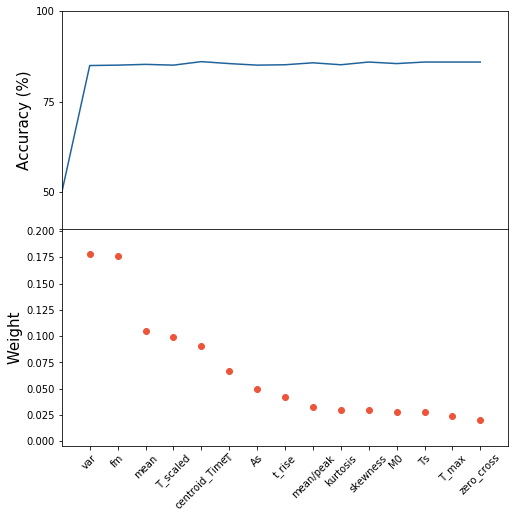

Average accuracy, std:
 0.852263948497854 0.010698124393296916
-----------------------------------

Intermediate-depth vs deep-focus

depth: 4 estimator 100


Training: 281; Testing: 281
Classification accuracy 0.744
[[ 98  43]
 [ 29 111]]
Feature importance:
mean 0.108
As 0.103
T_scaled 0.098
fm 0.078
T_max 0.073
M0 0.072
var 0.067
t_rise 0.064
T 0.062
zero_cross 0.061
centroid_Time 0.050
Ts 0.044
skewness 0.044
mean/peak 0.041
kurtosis 0.035


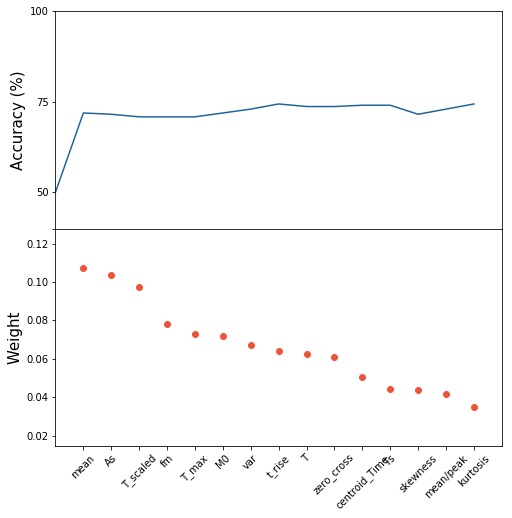

Average accuracy, std:
 0.7091814946619217 0.02777661571707876
	dichotomy

shallow	vs	deep:

dichotomous accuracies:
 Feature	Acc.	std
 [['M0' '0.5130364806866952' '0.009506916108059742']
 ['T' '0.7108208154506441' '0.005509034989229343']
 ['T_scaled' '0.8100321888412022' '0.005368292858836916']
 ['centroid_Time' '0.807741416309013' '0.005454536623957361']
 ['mean' '0.8081223175965663' '0.004343983205970931']
 ['t_rise' '0.7242596566523608' '0.006630684261070545']
 ['var' '0.833927038626609' '0.005465429743970981']
 ['skewness' '0.5377682403433475' '0.006337742242756371']
 ['kurtosis' '0.5086158798283266' '0.00703989409450398']
 ['mean/peak' '0.5534549356223177' '0.006852486102635133']
 ['zero_cross' '0.6435139484978536' '0.0058264346603851885']
 ['fm' '0.8514860515021457' '0.004420714793939872']
 ['T_max' '0.5151716738197426' '0.008404472946184112']
 ['Ts' '0.5269259656652358' '0.006851719540820752']
 ['As' '0.7128969957081547' '0.006688053215429097']]

Intermediate-depth	vs	deep-fouc

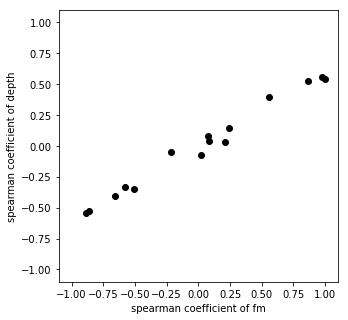


Depth>60 km
spearman coefficient:
Feature	depth	fm	T
 [['M0' '0.165' '0.072' '-0.064']
 ['T' '-0.139' '-0.452' '0.57']
 ['T_scaled' '-0.425' '-0.816' '1.0']
 ['centroid_Time' '-0.339' '-0.824' '0.865']
 ['mean' '0.425' '0.816' '-1.0']
 ['t_rise' '-0.242' '-0.63' '0.629']
 ['var' '0.374' '0.962' '-0.872']
 ['skewness' '-0.117' '0.127' '0.392']
 ['kurtosis' '-0.091' '0.028' '0.425']
 ['mean/peak' '0.108' '-0.113' '-0.422']
 ['zero_cross' '-0.123' '-0.408' '0.616']
 ['fm' '0.384' '1.0' '-0.816']
 ['T_max' '0.128' '0.022' '-0.183']
 ['Ts' '0.024' '0.218' '-0.108']
 ['As' '0.356' '0.489' '-0.714']]


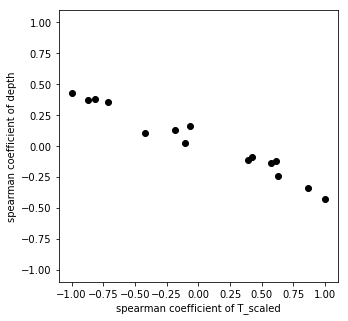

In [3]:
if __name__ == '__main__':
    # make file
    if not os.path.exists("out/"):
        os.makedirs('out/')
    
    #load data
    df =pd.read_csv('All_data_feature.csv')
    
    # Shallow, intermediate-depth and deep-focus earthquake
    df_shallow =df.loc[df['depth']<=60].copy()
    df_deep =df.loc[(df['depth']>60) & (df['depth']<=700)].copy()
    df_intermediate =df.loc[(df['depth']>60) & (df['depth']<=300)].copy()
    df_deep_focus =df.loc[(df['depth']>300) & (df['depth']<=700)].copy()
    print("The counts of EQS:\nShallow\tdeep\tintermediate-depth\tdeep-focus")
    print(len(df), len(df_shallow), len(df_intermediate), len(df_deep_focus))
    
    features = False

    #------------------------------------------------#
    # Random Forest
    # Shallow vs deep
    print('\nShallow vs deep\n')
    max_depth, n_estimators = 8, 90
    print("depth:", max_depth, "estimator", n_estimators)
    RF_feature(df_shallow, df_deep, max_depth, n_estimators, 'shallow_deep_predict', features=features)
    RF_score(df_shallow, df_deep, max_depth, n_estimators, features=features)
    print('-----------------------------------')
    
    # Intermediate-depth vs deep-focus
    print('\nIntermediate-depth vs deep-focus\n')
    max_depth, n_estimators = 4, 100
    print("depth:", max_depth, "estimator", n_estimators)
    RF_feature(df_intermediate, df_deep_focus, max_depth, n_estimators, 'intermediate_deepfocus_predict', features=features)
    RF_score(df_intermediate, df_deep_focus, max_depth, n_estimators, features=features)
    #------------------------------------------------#

    #--------------------------------------------------#
    # dichotomy
    #deep vs shallow
    print("\tdichotomy")
    print('\nshallow\tvs\tdeep:\n')
    linear_score(df_shallow, df_deep, features=False)
    #intermediate vs deep focus
    print('\nIntermediate-depth\tvs\tdeep-foucus:\n')
    linear_score(df_intermediate, df_deep_focus, features=False)
    #--------------------------------------------------#
    
    #--------------------------------------------------#
    # spearman coefficient
    # All depth
    print("Spearmean coefficient")
    print("All_depth")
    X = df.drop(columns=['depth', 'Er/Mw', 'apparent_stress']).copy()
    # depth, fm, T coefficient
    depth_coef = spearman_value(df, X, "depth")
    fm_coef = spearman_value(df, X, "fm")
    T_coef = spearman_value(df, X, "T_scaled")
    
    # print, save, plot
    spearman_all = list(zip(X.columns, depth_coef, fm_coef, T_coef))
    print("spearman coefficient:\nFeature\tdepth\tfm\tT\n", np.array(spearman_all))
    np.savetxt('out/spearman_shallow_deep', spearman_all, fmt="%s", header="depth\tfm\tT\t")
    plot_spearman(depth_coef, fm_coef)
    
    # > 60 km
    print("\nDepth>60 km")
    df_deep =df.loc[(df['depth']>60) & (df['depth']<=700)].copy()
    X_deep = df_deep.drop(columns=['depth', 'Er/Mw', 'apparent_stress'])
    
    # depth, fm, T coefficient
    deep_depth_coef = spearman_value(df_deep, X_deep, "depth")
    deep_fm_coef = spearman_value(df_deep, X_deep, "fm")
    deep_T_coef = spearman_value(df_deep, X_deep, "T_scaled")
    spearman_all = list(zip(X.columns, deep_depth_coef, deep_fm_coef, deep_T_coef))
    
    #print, save, plot
    print("spearman coefficient:\nFeature\tdepth\tfm\tT\n", np.array(spearman_all))
    np.savetxt('out/spearman_inter_deep.txt', spearman_all, fmt="%s")
    plot_spearman(deep_depth_coef, deep_T_coef, "T_scaled")
    #--------------------------------------------------#